In [190]:
# usual packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import h5py

import sys
#sys.modules.pop('CLASS_BABY')
#sys.modules.pop('CLASS_SAMPLE')


from CLASS_BABY import *
from CLASS_SAMPLE import *

import scipy.stats as ss

#bigger fonts
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rcParams.update({'font.size': 20})

# machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler#,Imputer

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

import tensorflow as tf

In [191]:
def median_in_bins_err(x,y,x1,x2,nbins,p1=0.25,p2=0.75):
    medians_x = np.zeros(nbins)
    medians_y = np.zeros(nbins)
    err_y_low = np.zeros(nbins)
    err_y_high = np.zeros(nbins)
    x = np.array(x)
    y = np.array(y)
    width = (float(x2)-float(x1))/nbins
    for i in range(int(nbins)):
        x_low = x1 + i*width
        x_high = x1+ (i+1)*width
        #print x_low, x_high
        sel = np.where((x>x_low)&(x<x_high))
        temp_ord = np.copy(y[sel])
        temp_ord = np.sort(temp_ord)
        medians_y[i] = temp_ord[int(len(temp_ord)*0.50 + 0.5)]
        err_y_low[i]  = np.abs(temp_ord[int(len(temp_ord)*p1 + 0.5)]-medians_y[i])
        err_y_high[i]  = np.abs(temp_ord[int(len(temp_ord)*p2 + 0.5)]-medians_y[i])
        #err_y[i] = [err_y_low,err_y_high]
        medians_x[i] = np.median(x[sel])
    return np.array(medians_x),np.array(medians_y),err_y_low,err_y_high

In [192]:
#pr,spo2,med_pr,med_spo2 = np.loadtxt('../TOST_data/total_datapoints.txt',unpack=True)
pr, spo2, pi, med_pr, med_spo2, med_pi = np.loadtxt('../TOST_data/total_datapoints_pi.txt',unpack=True)

In [193]:
#good_val = np.where(((~np.isnan(pr))&(~np.isnan(spo2))&(~np.isnan(med_pr))&(~np.isnan(med_spo2))))
#good_val = np.where(((pr>10.)&(spo2>10)&(med_pr>10.)&(med_spo2>10)))
good_val = np.where(((pr>10.)&(spo2>10)&(med_pr>10.)&(med_spo2>10)&(pi>0.000001)&(pi<100)))

In [194]:
len(med_pr[good_val])

928494

In [195]:
#INPUT = np.array([pr[good_val],med_pr[good_val],pi[good_val],med_pi[good_val]],dtype=float).T #med_spo2[good_val]
INPUT = np.array([pi[good_val],med_pi[good_val],med_spo2[good_val],spo2[good_val]],dtype=float).T # [pr[good_val],med_pr[good_val]

In [196]:
INPUT.shape

(928494, 4)

In [197]:
INPUT[0]

array([ 0.6,  0.7, 95. , 96. ])

In [198]:
# check that there is no NaN values in the input
np.unique(np.isnan(INPUT))

array([False])

In [199]:
#np.where(np.isnan(INPUT))

In [200]:
#OUTPUT = np.array(spo2[good_val],dtype=float)
OUTPUT = np.array(pr[good_val],dtype=float)

In [201]:
OUTPUT.shape

(928494,)

In [202]:
OUTPUT

array([117., 119., 121., ..., 123., 122., 122.])

In [203]:
INPUT_NORM = INPUT

In [204]:
# NORMALIZATION
scaler = StandardScaler()
scaler.fit(INPUT)
INPUT_NORM = scaler.transform(INPUT)


In [205]:
# SPLIT TRAIN AND TEST
input_train,input_test, output_train, output_test = train_test_split(INPUT_NORM, OUTPUT, test_size=0.3)

In [206]:
print ("training sample size: ",len(input_train))
print ("test sample size: ",len(input_test))
print ("train + test (total sample) = ", len(input_train)+len(input_test))
print ("train / sample =", round(float(len(input_train))/float(len(INPUT_NORM)),1))
print ("test / sample =", round(float(len(input_test))/float(len(INPUT_NORM)),1))

training sample size:  649945
test sample size:  278549
train + test (total sample) =  928494
train / sample = 0.7
test / sample = 0.3


In [207]:
# DEFINE MODEL ARCHITECTURE
model = Sequential()
model.add(Dense(6,input_dim=4,activation='relu'))
#model.add(Dense(6,activation='relu'))
model.add(Dense(3,activation='relu'))
model.add(Dense(1,activation='linear'))

In [208]:
# CREATE MODEL 
model.compile(loss='mean_squared_error', # 'mean_absolute_error' 
              optimizer='adam',
              metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])
              #metrics=[tf.keras.metrics.mean_squared_error])
              #metrics=['accuracy','f1-score'] ) 

In [209]:
# TRAIN THE MODEL

# stop training if after 10 iterations 
# the results has not improved
early_stopping = EarlyStopping(monitor='loss',
                               patience=10)

N_EPOCHS = 150
BATCH_SIZE = 1000
VALIDATION_FRACTION = 0.33
hist = model.fit(input_train,
                 output_train,
                 epochs=N_EPOCHS,
                 shuffle=False,
                 batch_size=BATCH_SIZE,
                 validation_split=VALIDATION_FRACTION,
                 callbacks=[early_stopping])

Train on 435463 samples, validate on 214482 samples
Epoch 1/150
435463/435463 [==============================] - 1s 3us/step - loss: 13968.8853 - mean_squared_error: 13968.8853 - mean_absolute_error: 116.8091 - mean_absolute_percentage_error: 94.9538 - cosine_proximity: -0.9998 - val_loss: 10861.9495 - val_mean_squared_error: 10861.9495 - val_mean_absolute_error: 102.3216 - val_mean_absolute_percentage_error: 82.9752 - val_cosine_proximity: -1.0000
Epoch 2/150
435463/435463 [==============================] - 1s 2us/step - loss: 6314.5105 - mean_squared_error: 6314.5105 - mean_absolute_error: 72.1928 - mean_absolute_percentage_error: 58.3764 - cosine_proximity: -1.0000 - val_loss: 3276.3694 - val_mean_squared_error: 3276.3694 - val_mean_absolute_error: 48.9019 - val_mean_absolute_percentage_error: 39.7157 - val_cosine_proximity: -1.0000
Epoch 3/150
435463/435463 [==============================] - 1s 2us/step - loss: 2118.1669 - mean_squared_error: 2118.1669 - mean_absolute_error: 37.546

Epoch 22/150
435463/435463 [==============================] - 2s 4us/step - loss: 274.0712 - mean_squared_error: 274.0712 - mean_absolute_error: 12.5296 - mean_absolute_percentage_error: 10.8129 - cosine_proximity: -1.0000 - val_loss: 273.4565 - val_mean_squared_error: 273.4565 - val_mean_absolute_error: 12.5375 - val_mean_absolute_percentage_error: 10.7798 - val_cosine_proximity: -1.0000
Epoch 23/150
435463/435463 [==============================] - 1s 3us/step - loss: 274.0530 - mean_squared_error: 274.0530 - mean_absolute_error: 12.5293 - mean_absolute_percentage_error: 10.8127 - cosine_proximity: -1.0000 - val_loss: 273.4316 - val_mean_squared_error: 273.4316 - val_mean_absolute_error: 12.5372 - val_mean_absolute_percentage_error: 10.7799 - val_cosine_proximity: -1.0000
Epoch 24/150
435463/435463 [==============================] - 1s 2us/step - loss: 274.0384 - mean_squared_error: 274.0384 - mean_absolute_error: 12.5291 - mean_absolute_percentage_error: 10.8126 - cosine_proximity: -

Epoch 43/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.9480 - mean_squared_error: 273.9480 - mean_absolute_error: 12.5270 - mean_absolute_percentage_error: 10.8107 - cosine_proximity: -1.0000 - val_loss: 273.3236 - val_mean_squared_error: 273.3236 - val_mean_absolute_error: 12.5346 - val_mean_absolute_percentage_error: 10.7777 - val_cosine_proximity: -1.0000
Epoch 44/150
435463/435463 [==============================] - 1s 3us/step - loss: 273.9465 - mean_squared_error: 273.9465 - mean_absolute_error: 12.5269 - mean_absolute_percentage_error: 10.8106 - cosine_proximity: -1.0000 - val_loss: 273.3216 - val_mean_squared_error: 273.3216 - val_mean_absolute_error: 12.5344 - val_mean_absolute_percentage_error: 10.7776 - val_cosine_proximity: -1.0000
Epoch 45/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.9451 - mean_squared_error: 273.9451 - mean_absolute_error: 12.5269 - mean_absolute_percentage_error: 10.8106 - cosine_proximity: -

Epoch 64/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.9214 - mean_squared_error: 273.9214 - mean_absolute_error: 12.5263 - mean_absolute_percentage_error: 10.8100 - cosine_proximity: -1.0000 - val_loss: 273.2975 - val_mean_squared_error: 273.2975 - val_mean_absolute_error: 12.5341 - val_mean_absolute_percentage_error: 10.7768 - val_cosine_proximity: -1.0000
Epoch 65/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.9201 - mean_squared_error: 273.9201 - mean_absolute_error: 12.5262 - mean_absolute_percentage_error: 10.8099 - cosine_proximity: -1.0000 - val_loss: 273.2966 - val_mean_squared_error: 273.2966 - val_mean_absolute_error: 12.5340 - val_mean_absolute_percentage_error: 10.7767 - val_cosine_proximity: -1.0000
Epoch 66/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.9190 - mean_squared_error: 273.9190 - mean_absolute_error: 12.5262 - mean_absolute_percentage_error: 10.8099 - cosine_proximity: -

Epoch 85/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8963 - mean_squared_error: 273.8963 - mean_absolute_error: 12.5251 - mean_absolute_percentage_error: 10.8091 - cosine_proximity: -1.0000 - val_loss: 273.2676 - val_mean_squared_error: 273.2676 - val_mean_absolute_error: 12.5328 - val_mean_absolute_percentage_error: 10.7758 - val_cosine_proximity: -1.0000
Epoch 86/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8953 - mean_squared_error: 273.8953 - mean_absolute_error: 12.5251 - mean_absolute_percentage_error: 10.8091 - cosine_proximity: -1.0000 - val_loss: 273.2666 - val_mean_squared_error: 273.2666 - val_mean_absolute_error: 12.5328 - val_mean_absolute_percentage_error: 10.7757 - val_cosine_proximity: -1.0000
Epoch 87/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8945 - mean_squared_error: 273.8945 - mean_absolute_error: 12.5251 - mean_absolute_percentage_error: 10.8091 - cosine_proximity: -

Epoch 106/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8804 - mean_squared_error: 273.8804 - mean_absolute_error: 12.5249 - mean_absolute_percentage_error: 10.8089 - cosine_proximity: -1.0000 - val_loss: 273.2489 - val_mean_squared_error: 273.2489 - val_mean_absolute_error: 12.5326 - val_mean_absolute_percentage_error: 10.7755 - val_cosine_proximity: -1.0000
Epoch 107/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8800 - mean_squared_error: 273.8800 - mean_absolute_error: 12.5249 - mean_absolute_percentage_error: 10.8090 - cosine_proximity: -1.0000 - val_loss: 273.2484 - val_mean_squared_error: 273.2484 - val_mean_absolute_error: 12.5326 - val_mean_absolute_percentage_error: 10.7755 - val_cosine_proximity: -1.0000
Epoch 108/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8798 - mean_squared_error: 273.8798 - mean_absolute_error: 12.5249 - mean_absolute_percentage_error: 10.8089 - cosine_proximity

Epoch 127/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8738 - mean_squared_error: 273.8738 - mean_absolute_error: 12.5248 - mean_absolute_percentage_error: 10.8089 - cosine_proximity: -1.0000 - val_loss: 273.2412 - val_mean_squared_error: 273.2412 - val_mean_absolute_error: 12.5325 - val_mean_absolute_percentage_error: 10.7754 - val_cosine_proximity: -1.0000
Epoch 128/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8736 - mean_squared_error: 273.8736 - mean_absolute_error: 12.5248 - mean_absolute_percentage_error: 10.8089 - cosine_proximity: -1.0000 - val_loss: 273.2409 - val_mean_squared_error: 273.2409 - val_mean_absolute_error: 12.5325 - val_mean_absolute_percentage_error: 10.7754 - val_cosine_proximity: -1.0000
Epoch 129/150
435463/435463 [==============================] - 1s 3us/step - loss: 273.8733 - mean_squared_error: 273.8733 - mean_absolute_error: 12.5248 - mean_absolute_percentage_error: 10.8089 - cosine_proximity

Epoch 148/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8674 - mean_squared_error: 273.8674 - mean_absolute_error: 12.5248 - mean_absolute_percentage_error: 10.8088 - cosine_proximity: -1.0000 - val_loss: 273.2347 - val_mean_squared_error: 273.2347 - val_mean_absolute_error: 12.5324 - val_mean_absolute_percentage_error: 10.7753 - val_cosine_proximity: -1.0000
Epoch 149/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8672 - mean_squared_error: 273.8672 - mean_absolute_error: 12.5248 - mean_absolute_percentage_error: 10.8088 - cosine_proximity: -1.0000 - val_loss: 273.2342 - val_mean_squared_error: 273.2342 - val_mean_absolute_error: 12.5324 - val_mean_absolute_percentage_error: 10.7753 - val_cosine_proximity: -1.0000
Epoch 150/150
435463/435463 [==============================] - 1s 2us/step - loss: 273.8668 - mean_squared_error: 273.8668 - mean_absolute_error: 12.5247 - mean_absolute_percentage_error: 10.8088 - cosine_proximity

In [210]:
model.evaluate(input_test,output_test)

278549/278549 [==============================] - 6s 22us/step


[271.33746605417514,
 271.33746605417514,
 12.481258583504346,
 10.72200339935622,
 -0.9999999978909873]

In [211]:
l,a1,a2,a3,a4 = model.evaluate(input_test,output_test)#[0]
#l = model.evaluate(input_test,output_test)#[0]
#a=0
#a = model.evaluate(input_test,output_test)[1]
print('NUMBER OF INPUT VARIABLES = ',len(INPUT))
print('NUMBER OF EPOCHS = ',N_EPOCHS)
print('VALIDATION FRACTION = ',VALIDATION_FRACTION)
print('BATCH SIZE = ',BATCH_SIZE)
#print('Model loss function =\t%.2f\nModel Accuracy =\t%.2f'%(l,a1))
print('Model loss function =\t%.2f\nModel mse =\t%.2f'%(l,a1))

278549/278549 [==============================] - 6s 22us/step
NUMBER OF INPUT VARIABLES =  928494
NUMBER OF EPOCHS =  150
VALIDATION FRACTION =  0.33
BATCH SIZE =  1000
Model loss function =	271.34
Model mse =	271.34


In [212]:
print(hist.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity', 'loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])


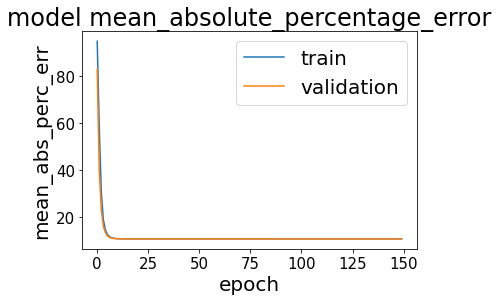

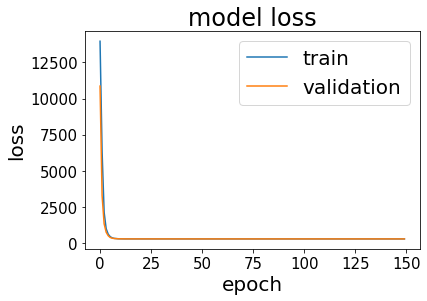

In [213]:
# summarize history for accuracy
#plt.plot(hist.history['acc'])
#plt.plot(hist.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='best')
#plt.show()

# summarize history for loss
plt.plot(hist.history['mean_absolute_percentage_error'])
plt.plot(hist.history['val_mean_absolute_percentage_error'])
plt.title('model mean_absolute_percentage_error')
plt.ylabel('mean_abs_perc_err')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [214]:
# prediction on the test sample
prediction = model.predict(input_test)

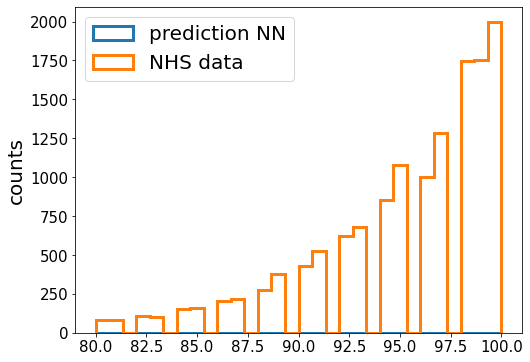

In [215]:
# distribution of prediction vs real data
plt.figure(figsize=(8,6))
plt.hist(prediction,bins=30,lw=3,histtype='step',label=r'prediction NN',range=(80,100)) # range=(0.,60.)
plt.hist(output_test,bins=30,lw=3,histtype='step',label=r'NHS data',range=(80,100))
#plt.xlabel('number of episodes of bradycardia (thr 120)',fontsize=20)
#plt.xlabel('ratio of time in bradycardia',fontsize=20)
plt.ylabel('counts',fontsize=20)
plt.legend(fontsize=20,loc=2)
plt.show()

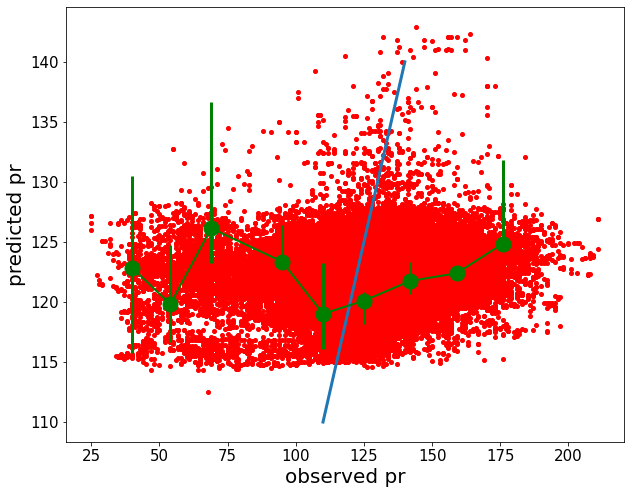

In [219]:
# plot of prediction vs real data
plt.figure(figsize=(10,8))
#plt.plot([0.,60.],[0.,60.],'k')
#plt.plot([0.,1.2],[0.,1.2],'k')

xx,yy,ey1,ey2 = median_in_bins_err(output_test,prediction,25,190,9)
plt.errorbar(xx,yy,yerr=[ey1,ey2],fmt=".",markersize=30,elinewidth=3,color='green',zorder=11,label='THR 100')
plt.plot(xx,yy,color="green",lw=2,zorder=12)


plt.plot(output_test,prediction,".r",markersize=8)
#plt.xlim(-0.5,20.)
#plt.ylim(-0.5,20.)
#plt.xlabel(r'number of brady-episodes observed',fontsize=20)
#plt.ylabel(r'number of brady-episodes predicted',fontsize=20)

#plt.xlabel(r'observed spo2',fontsize=20)
#plt.ylabel(r'predicted spo2',fontsize=20)

#plt.plot([80.,180.],[80.,180.],lw=3)
plt.plot([110.,140.],[110.,140.],lw=3)


plt.xlabel(r'observed pr',fontsize=20)
plt.ylabel(r'predicted pr',fontsize=20)


plt.show()

In [34]:
residuals = np.array(output_test[0:10000])-np.array(prediction[0:10000])

In [ ]:
plt.plot(residuals,output_test[0:10000],".r",markersize=8)

In [27]:
len(prediction)

464247

In [28]:
prediction

array([[95.51604 ],
       [98.08901 ],
       [93.068275],
       ...,
       [93.48881 ],
       [98.019646],
       [96.026535]], dtype=float32)